# Análisis de Predicción de Accidentes Cerebrovasculares

Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular es la segunda causa de muerte a nivel mundial y es responsable de aproximadamente el 11 % del total de muertes.
Este conjunto de datos se utiliza para predecir si un paciente tiene probabilidades de sufrir un accidente cerebrovascular en función de los parámetros de entrada, como el sexo, la edad, diversas enfermedades y el tabaquismo. Cada fila de los datos proporciona información relevante sobre el paciente.

Para la realización del siguiente modelo se utilizo el Dataset de [ kaggle - Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download)



Integrantes 
------------

|N° SIU|Nombre	            |Apellido	            |email|
|---   |---------------		|-------------------    |------|
|a1720 |Naile Paola	        |Cartalá	            |  paola.cartala@gmail.com|
|a1819 |Manuel	            |Pineyro	            |manuel.o.pineyro@gmail.com|
|a1802 |Ezequiel Alejandro	|Caamaño	            |ezecaa@gmail.com|
|a1823 |Luis Alberto	    |Santamaría Jimenez	    |santamaria.luigi@gmail.com|


## Configuración y Carga de Datos


# Configuración Inicial y Carga de Datos
En esta sección, configuramos el entorno de análisis, importamos las bibliotecas necesarias
y realizamos una exploración inicial de los datos.



In [8]:
# Configuración del entorno y verificación de datos
import os
from pathlib import Path

try:
    from google.colab import drive
    IN_COLAB = True
    print("Ejecutando en Colab - Configurando entorno...")
    
    # Clonar el repositorio
    !git clone https://github.com/MOPineyro/prediccion_accidentes_cerebrovasculares.git
    %cd prediccion_accidentes_cerebrovasculares
    
    # Instalar dependencias
    %!pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn scipy torch
    
    # Verificar que existan los directorios necesarios
    !mkdir -p data results
    
    # Verificar que existe el dataset
    if not os.path.exists('data/healthcare-dataset-stroke-data.csv'):
        print("ERROR: No se encuentra el archivo de datos en data/healthcare-dataset-stroke-data.csv")
        print("Por favor, verifica que el repositorio se clonó correctamente")
    else:
        print("Dataset encontrado correctamente")
    
except:
    IN_COLAB = False
    print("Ejecutando localmente - Usando entorno existente")

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDispositivo en uso: {device}")

Ejecutando localmente - Usando entorno existente

Dispositivo en uso: cpu


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Configuración de visualización
plt.style.use('seaborn-v0_8')  # Usando un estilo válido de matplotlib
sns.set_theme()  # Aplicar el tema de seaborn
pd.set_option('display.max_columns', None)



## Carga y Vista Preliminar de Datos
Cargamos el conjunto de datos y examinamos su estructura básica



In [10]:
def load_stroke_data(filepath: str) -> pd.DataFrame:
    """
    Carga el conjunto de datos de predicción de accidentes cerebrovasculares
    
    """
    # Cargamos los datos
    df = pd.read_csv(filepath)
    return df



In [11]:
def initial_data_summary(df: pd.DataFrame) -> None:
    """
    Genera un resumen inicial del conjunto de datos
    """
    # Información básica del dataset
    print("=== Información del Dataset ===")
    print("\nDimensiones del dataset:", df.shape)
    print("\nColumnas disponibles:")
    print(df.columns.tolist())
    
    # Resumen estadístico básico
    print("\n=== Resumen Estadístico ===")
    print(df.describe())
    
    # Información sobre tipos de datos y valores nulos
    print("\n=== Información de Tipos de Datos y Valores Nulos ===")
    print(df.info())



In [12]:
DATA_PATH = "data/healthcare-dataset-stroke-data.csv"

try:
    stroke_data = load_stroke_data(DATA_PATH)
    
    # Generación de resumen inicial
    initial_data_summary(stroke_data)
    
except FileNotFoundError:
    print("Error: No se encontró el archivo de datos en la ruta especificada.")
    print("Por favor, verifica que el archivo existe en:", DATA_PATH) 


=== Información del Dataset ===

Dimensiones del dataset: (5110, 12)

Columnas disponibles:
['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

=== Resumen Estadístico ===
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677   


## Análisis Exploratorio


# Análisis Exploratorio de Datos
En esta sección realizamos un análisis exploratorio detallado del conjunto de datos
para entender mejor las características y relaciones entre variables.



In [13]:
DATA_PATH = "data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(DATA_PATH)



## Análisis Exploratorio (EDA)  -cuadros-
A continuación  realizamos un EDA del dataset para identificar datos atípicos y anomalías, detectar valores faltantes o nulos, comprender la distribución de las variables y explorar las relaciones entre las variables.

In [14]:
# Tabla resumen de estructura del Dataset
# Variable temporal solo para la exploración  del dataframe
df_explorar = df
# Función exploración del DataFrame
def analisis_detallado(df):
    df_numeros = df.select_dtypes(exclude=['object'])
    
    # Calcular la moda, manejando casos de múltiples valores
    moda_serie = df_numeros.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    resumen = pd.DataFrame({
        #'num_colum': range(1, len(df.columns) + 1),  # Crea números secuenciales
        # Tipo de dato
        'Tipo_Dato': df.dtypes,
        #'Total_Registros': len(df_explorar),
        # Cantidad de valores únicos
        'Valor_Unico': df.nunique(),
        # Cantidad de valores Null -> NaN
        'Null': df.isnull().sum(),
        # % de campos Null
        'Null%': (df.isnull().sum() / len(df) * 100).round(2),
        # Cantidad de campos Not Null
        'NotNull': df.count(),
        # % de campos Not Null
        'NotNull%': (df.count() / len(df) * 100).round(2),
        # cuenta valores =0   -- suma la cantidad de x que contiene los valores que indica la regla
        'var=0': df.apply(lambda x: (x == 0).sum() if pd.api.types.is_numeric_dtype(x) else 0),
        # % de valor 0 
        '%var=0': (df.apply(lambda x: (x == 0).sum() if pd.api.types.is_numeric_dtype(x) else 0) / len(df) * 100).round(2),
        # cuenta valores <1  -- suma la cantidad de x que contiene los valores que indica la regla
        'var<1': df.apply(lambda x: (x < 1).sum() if pd.api.types.is_numeric_dtype(x) else 0),
        # % de valores <1 
        '%var<1': (df.apply(lambda x: (x < 1).sum() if pd.api.types.is_numeric_dtype(x) else 0) / len(df) * 100).round(2),
        # % de valor distinto de 0
        #'%sin_0': (df.apply(lambda x: (x != 0).sum() if pd.api.types.is_numeric_dtype(x) else 0) / len(df) * 100).round(2),
        ## Suma de valores 0.0 para columnas float
        #'Sum_0.0': df.apply(lambda x: (x == 0.0).sum() if pd.api.types.is_float_dtype(x) else 0),
        ## Porcentaje de ceros (testing - Error en el %)
        ##'Porcentaje_Ceros%': (df.apply(lambda x: (x == 0).sum() if pd.api.types.is_numeric_dtype(x) else 0) / len(df) * 100).round(2),
        # Valor mínimo
        #'Valor.min': df_numeros.min(),
        # Valor máximo
        #'Valor_max': df_numeros.max(),
        # Promedio
        'Valor_mean': df_numeros.mean(),
        # Moda
        'Valor_moda': moda_serie
        # Desviación estándar
        #'std': df_numeros.std()
    })
    
    return resumen

# Usar la función
tabla_resumen_df = analisis_detallado(df_explorar)
# Salida en pantalla 
print(f"Matriz DataSet: {df_explorar.shape}")
print(f"Cantidad total de registros: {len(df_explorar)} \n")
print("TABLA DE ESTRUCTURA DEL DATASET")
# MODO DE VISUALIZACIÓN -0 NATIVO DEL JUPYTER 
#tabla_resumen_df
# MODO DE VISUALIZACIÓN -1 
# llama el resultado de la función analisis_detallado 3 métodos para la visualización de la información .to_string():convierte el DataFrame en una cadena de texto, display función html de panda 
#print(tabla_resumen_df.to_string())
# MODO DE VISUALIZACIÓN -2
display(tabla_resumen_df)

del df_explorar, tabla_resumen_df

Matriz DataSet: (5110, 12)
Cantidad total de registros: 5110 

TABLA DE ESTRUCTURA DEL DATASET


,Tipo_Dato,Valor_Unico,Null,Null%,NotNull,NotNull%,var=0,%var=0,var<1,%var<1,Valor_mean,Valor_moda
Residence_type,object,2,0,0.00,5110,100.00,0,0.00,0,0.00,NaN,NaN
age,float64,104,0,0.00,5110,100.00,0,0.00,43,0.84,43.226614,78.00
avg_glucose_level,float64,3979,0,0.00,5110,100.00,0,0.00,0,0.00,106.147677,93.88
bmi,float64,418,201,3.93,4909,96.07,0,0.00,0,0.00,28.893237,28.70
ever_married,object,2,0,0.00,5110,100.00,0,0.00,0,0.00,NaN,NaN
gender,object,3,0,0.00,5110,100.00,0,0.00,0,0.00,NaN,NaN
heart_disease,int64,2,0,0.00,5110,100.00,4834,94.60,4834,94.60,0.054012,0.00
hypertension,int64,2,0,0.00,5110,100.00,4612,90.25,4612,90.25,0.097456,0.00
id,int64,5110,0,0.00,5110,100.00,0,0.00,0,0.00,36517.829354,67.00
smoking_status,object,4,0,0.00,5110,100.00,0,0.00,0,0.00,NaN,NaN


In [15]:
# Deserción  valores numéricos del dataframe
print (f"Tabla describe de los valores numéricos del dataset")
df.describe().T

Tabla describe de los valores numéricos del dataset


,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [16]:
print (f"Tabla describe de los valores strings del dataset")
# Deserción  valores strings del dataframe
df.describe(include=object).T

Tabla describe de los valores strings del dataset


,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
Residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


In [17]:
print (f" Tabla de registros al azar pero filtrado por ( bmi -> isnull)  (bmi -> notnull) (age > 0) ")
############ Consulta combinada fare_amount Valores Atípicos 
consulta_filtro_U = df.loc[df['bmi'].isnull()].sample(3)
consulta_filtro_D = df.loc [(df['bmi'].notnull()) & (df['age'] > 0)].sample(4)
consulta_filtro_T = df.loc[df['age'] < 1].sample(4)
consulta_filtro_C = df.loc[df['gender'] == 'Other']
# Combinar ambos resultados
consulta_filtro = pd.concat([consulta_filtro_U,consulta_filtro_D,consulta_filtro_T, consulta_filtro_C])

## .T (transposición atributo de pandas) lo aplicamos de manera directa en el DataFrame caso de display y print 
display(consulta_filtro.T)

 Tabla de registros al azar pero filtrado por ( bmi -> isnull)  (bmi -> notnull) (age > 0) 


,70,1466,29,3210,103,2185,4346,2630,4645,3968,4581,3116
id,70676,44950,69160,72594,4712,53990,45325,61836,25783,41500,15728,56156
gender,Female,Male,Male,Male,Female,Male,Female,Female,Female,Male,Female,Other
age,76.0,51.0,59.0,63.0,81.0,64.0,29.0,0.8,0.48,0.16,0.4,26.0
hypertension,0,1,0,0,0,0,0,0,0,0,0,0
heart_disease,0,0,0,0,1,1,0,0,0,0,0,0
ever_married,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No
work_type,Govt_job,Private,Private,Private,Self-employed,Private,Private,children,children,children,children,Private
Residence_type,Rural,Rural,Rural,Urban,Rural,Urban,Urban,Urban,Rural,Rural,Rural,Rural
avg_glucose_level,62.57,163.56,211.78,95.29,78.7,211.35,61.13,106.59,94.06,69.79,85.65,143.33
bmi,NaN,NaN,NaN,31.6,19.4,30.7,26.0,15.5,14.8,13.0,17.4,22.4


In [18]:
# Tabla de valores único en los features tipo object
###################
# Variable temporal solo para la exploración  del dataframe
df_explorar = df
# función para agrupar la distribución de variables categóricas object
def distribucion_var_object(df):
    # Crear un DataFrame para agrupar la información de todas las columnas categóricas
    datos_agrupados = pd.DataFrame()
    
    # Seleccionar columnas de tipo object (categóricos)
    columnas_categoricas = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    
    # Recorrer y construir la tabla
    for columna in columnas_categoricas:
        conteo = df[columna].value_counts(dropna=False)
        df_conteo = pd.DataFrame({
            'Columna': columna,
            'Categoria': conteo.index,
            'Frecuencia': conteo.values        
        })
        datos_agrupados = pd.concat([datos_agrupados, df_conteo], ignore_index=True)
    
    return datos_agrupados
# Llamar a la función

datos_object_agrupados = distribucion_var_object(df_explorar)

print (f" Tabla de valores único en los features tipo object")
# Mostrar la tabla de datos agrupados
display(datos_object_agrupados)

# Borramos variables del dataframe
del df_explorar, datos_object_agrupados

 Tabla de valores único en los features tipo object


,Columna,Categoria,Frecuencia
0,gender,Female,2994
1,gender,Male,2115
2,gender,Other,1
3,ever_married,Yes,3353
4,ever_married,No,1757
5,work_type,Private,2925
6,work_type,Self-employed,819
7,work_type,children,687
8,work_type,Govt_job,657
9,work_type,Never_worked,22


## Análisis Demográfico
Exploramos las características demográficas básicas de la población



In [19]:
def analyze_demographics(df: pd.DataFrame) -> None:
    """
    Analiza y visualiza las características demográficas del dataset
    """
    # Distribución por género
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='gender')
    plt.title('Distribución por Género')
    plt.xlabel('Género')
    plt.ylabel('Cantidad')
    plt.show()
    
    # Distribución de edad
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='age', bins=30)
    plt.title('Distribución de Edad')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Edad por género
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='gender', y='age')
    plt.title('Distribución de Edad por Género')
    plt.show()



## Análisis de Factores de Riesgo
Exploramos las principales variables que pueden influir en el riesgo de accidente cerebrovascular



In [20]:
def analyze_risk_factors(df: pd.DataFrame) -> None:
    """
    Analiza y visualiza los principales factores de riesgo

    """
    # BMI distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='bmi', bins=30)
    plt.title('Distribución de IMC')
    plt.xlabel('IMC')
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Glucose levels
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='stroke', y='avg_glucose_level')
    plt.title('Niveles de Glucosa por Resultado')
    plt.xlabel('Accidente Cerebrovascular')
    plt.ylabel('Nivel Promedio de Glucosa')
    plt.show()
    
    # Hypertension and heart disease
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.countplot(data=df, x='hypertension', ax=ax1)
    ax1.set_title('Distribución de Hipertensión')
    
    sns.countplot(data=df, x='heart_disease', ax=ax2)
    ax2.set_title('Distribución de Enfermedad Cardíaca')
    
    plt.tight_layout()
    plt.show()



## Análisis de Correlaciones
Exploramos las relaciones entre las diferentes variables numéricas



In [21]:
def analyze_correlations(df: pd.DataFrame) -> None:
    """
    Analiza y visualiza las correlaciones entre variables numéricas
    
    """
    # Seleccionar variables numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Calcular correlaciones
    corr_matrix = df[numeric_cols].corr()
    
    # Visualizar matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación de Variables Numéricas')
    plt.show()



=== Análisis Demográfico ===


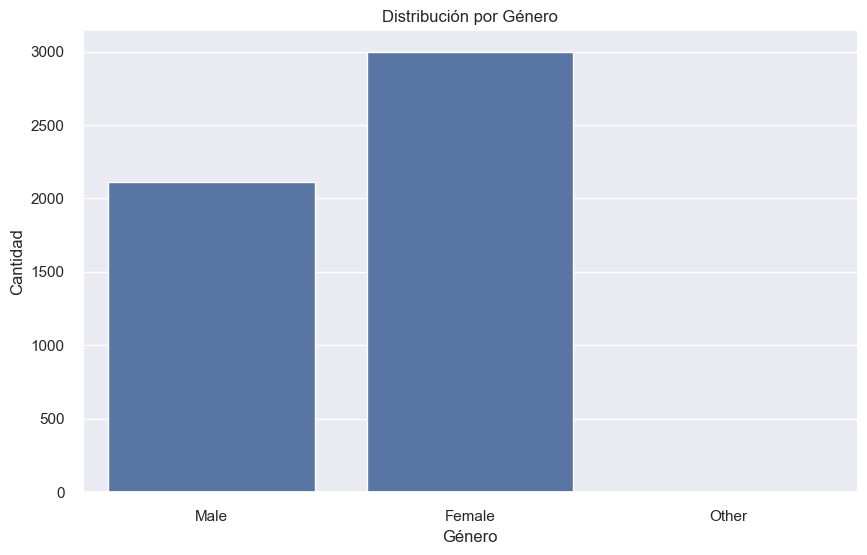

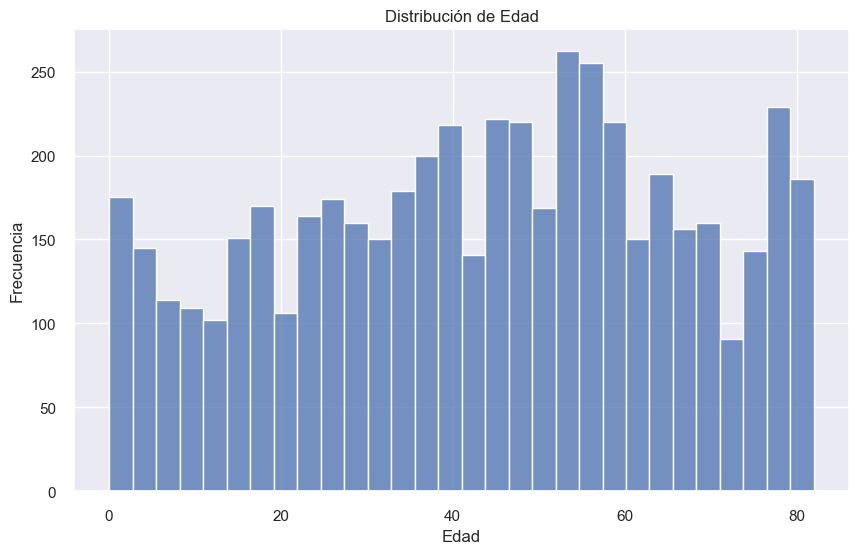

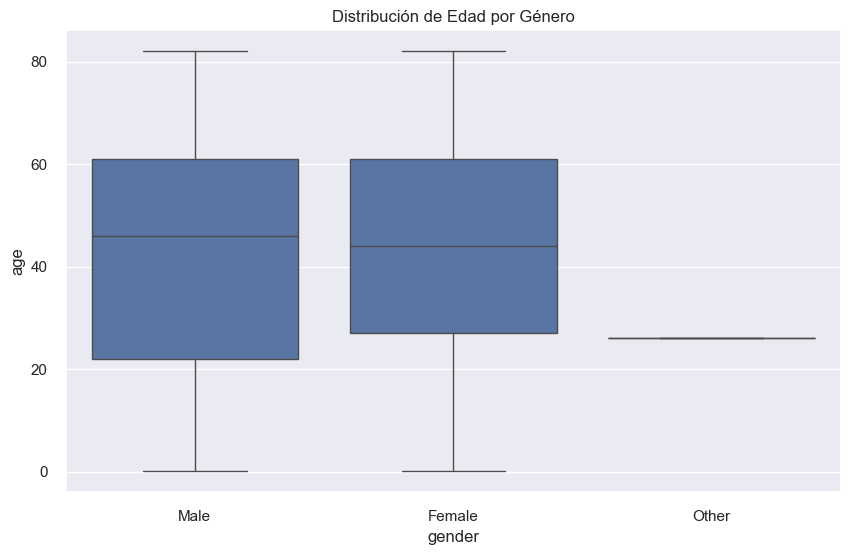


=== Análisis de Factores de Riesgo ===


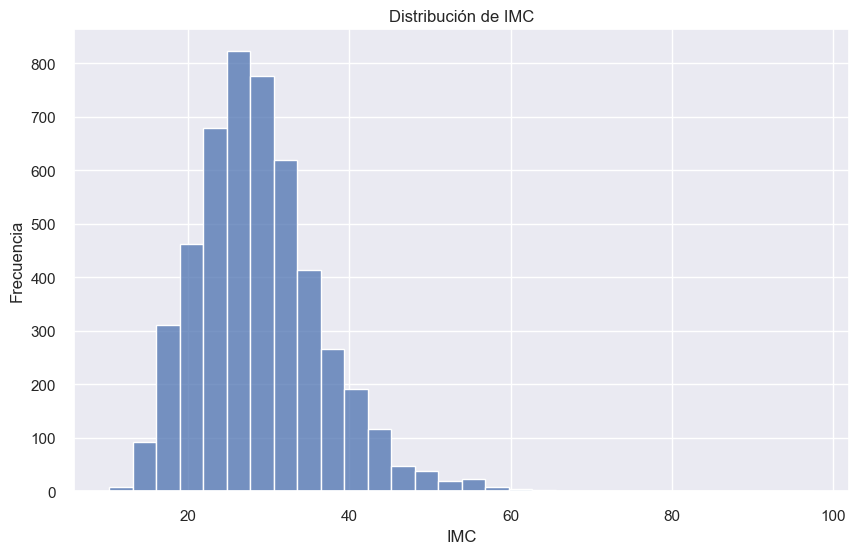

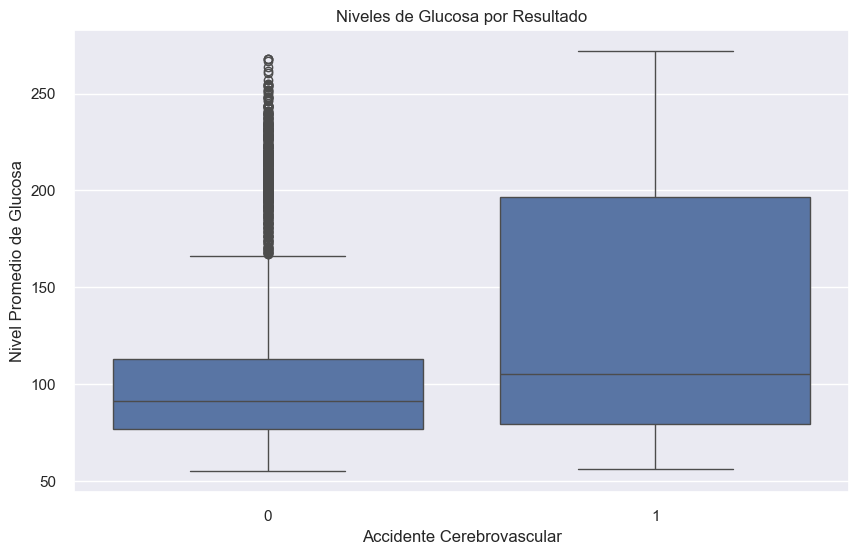

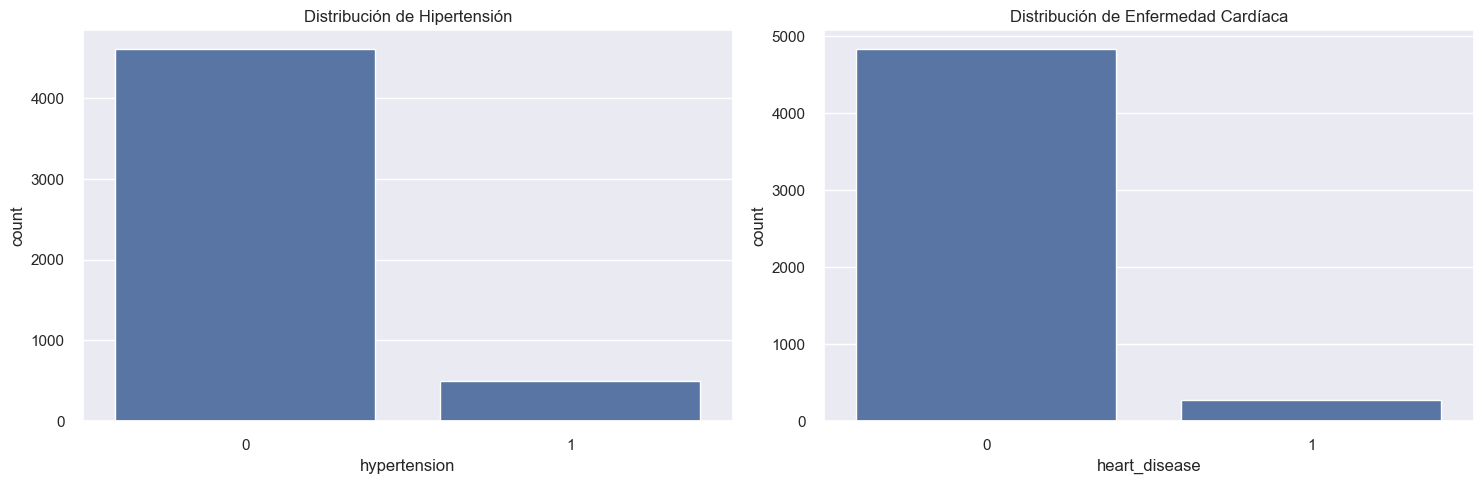


=== Análisis de Correlaciones ===


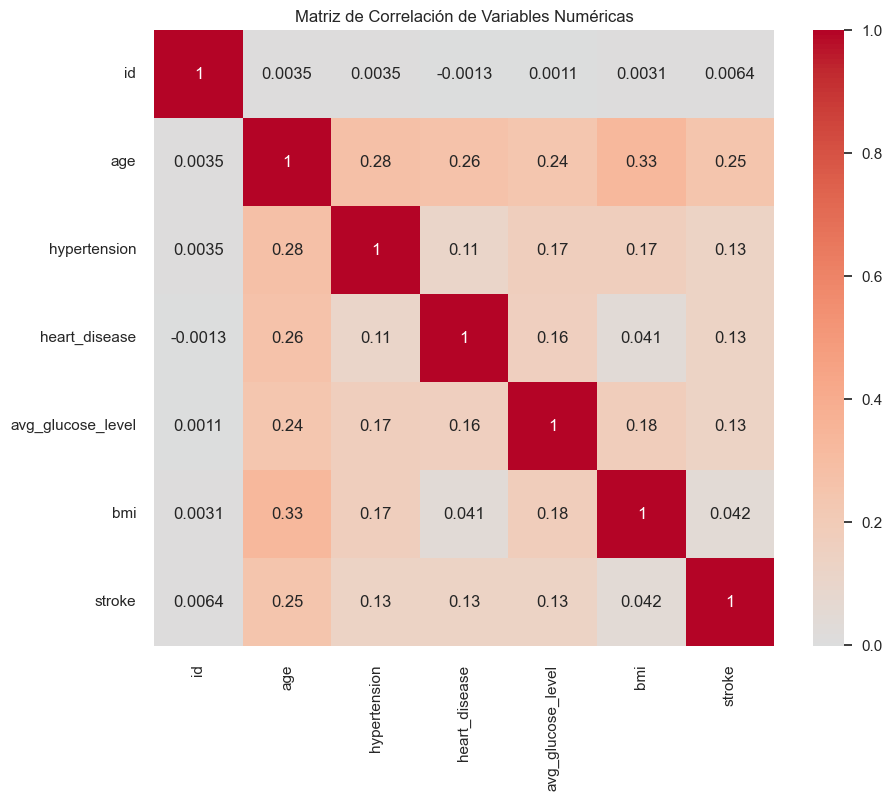

In [22]:
# Ejecutar análisis
# ----------------
print("=== Análisis Demográfico ===")
analyze_demographics(df)

print("\n=== Análisis de Factores de Riesgo ===")
analyze_risk_factors(df)

print("\n=== Análisis de Correlaciones ===")
analyze_correlations(df)




## Preprocesamiento


# Preprocesamiento de Datos
En esta sección realizamos la limpieza de datos y la ingeniería de características
para preparar el conjunto de datos para el modelado.



In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [24]:
DATA_PATH = "data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(DATA_PATH)

## Limpieza de Datos
Tratamiento de valores faltantes y datos atípicos



In [25]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Realiza la limpieza inicial del conjunto de datos
    """
    df_clean = df.copy()
    
    # Manejo de valores faltantes en BMI
    imputer = SimpleImputer(strategy='median')
    df_clean['bmi'] = imputer.fit_transform(df_clean[['bmi']])
    
    # Eliminar valores atípicos extremos en glucose_level
    q1 = df_clean['avg_glucose_level'].quantile(0.01)
    q3 = df_clean['avg_glucose_level'].quantile(0.99)
    df_clean = df_clean[
        (df_clean['avg_glucose_level'] >= q1) & 
        (df_clean['avg_glucose_level'] <= q3)
    ]
    
    return df_clean

## Ingeniería de Características
Creación de nuevas características y transformación de variables



In [26]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Realiza la ingeniería de características
    """
    df_engineered = df.copy()
    
    # Crear categorías de BMI
    df_engineered['bmi_category'] = pd.cut(
        df_engineered['bmi'],
        bins=[0, 18.5, 24.9, 29.9, np.inf],
        labels=['Bajo peso', 'Normal', 'Sobrepeso', 'Obeso']
    )
    
    # Crear categorías de edad
    df_engineered['age_group'] = pd.cut(
        df_engineered['age'],
        bins=[0, 18, 35, 50, 65, np.inf],
        labels=['<18', '18-35', '36-50', '51-65', '>65']
    )
    
    # Crear categorías de glucosa
    df_engineered['glucose_category'] = pd.cut(
        df_engineered['avg_glucose_level'],
        bins=[0, 70, 100, 125, np.inf],
        labels=['Bajo', 'Normal', 'Pre-diabetes', 'Diabetes']
    )
    
    return df_engineered

## Codificación de Variables
Transformación de variables categóricas para el modelado



In [27]:
def encode_variables(df: pd.DataFrame) -> pd.DataFrame:
    """
    Codifica las variables categóricas
    """
    df_encoded = df.copy()
    
    # Codificación de variables categóricas
    categorical_columns = ['gender', 'ever_married', 'work_type', 
                         'Residence_type', 'smoking_status',
                         'bmi_category', 'age_group', 'glucose_category']
    
    for column in categorical_columns:
        le = LabelEncoder()
        df_encoded[column] = le.fit_transform(df_encoded[column])
    
    return df_encoded

## Preparación Final
División de datos y escalado de características



In [28]:
def prepare_for_modeling(df: pd.DataFrame, 
                        target: str = 'stroke',
                        test_size: float = 0.2,
                        random_state: int = 42) -> tuple:
    """
    Prepara los datos para el modelado
    """
    # Separar características y objetivo
    X = df.drop(columns=[target])
    y = df[target]
    
    # División train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Escalado de características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [29]:
# Limpieza de datos
df_clean = clean_data(df)
print("Dimensiones después de limpieza:", df_clean.shape)

# Ingeniería de características
df_engineered = engineer_features(df_clean)
print("\nNuevas características creadas:", 
      [col for col in df_engineered.columns if col not in df_clean.columns])

# Codificación de variables
df_encoded = encode_variables(df_engineered)
print("\nVariables codificadas:", 
      [col for col in df_encoded.columns if df_encoded[col].dtype in ['int64', 'float64']])

# Preparación final
X_train, X_test, y_train, y_test, scaler = prepare_for_modeling(df_encoded)
print("\nDimensiones de los conjuntos de entrenamiento y prueba:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")



Dimensiones después de limpieza: (5006, 12)

Nuevas características creadas: ['bmi_category', 'age_group', 'glucose_category']

Variables codificadas: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke', 'bmi_category', 'age_group', 'glucose_category']

Dimensiones de los conjuntos de entrenamiento y prueba:
X_train: (4004, 14)
X_test: (1002, 14)



## Modelos Tradicionales


# Modelado Estándar
En esta sección implementamos y evaluamos diferentes modelos de machine learning
utilizando scikit-learn para la predicción de accidentes cerebrovasculares.



In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from model_results import ModelResults

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_theme()
pd.set_option('display.max_columns', None)


In [31]:
DATA_PATH = "data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(DATA_PATH)

# Aplicar preprocesamiento
df_clean = clean_data(df)
df_engineered = engineer_features(df_clean)
df_encoded = encode_variables(df_engineered)
X_train, X_test, y_train, y_test, scaler = prepare_for_modeling(df_encoded)

## Manejo del Desbalance de Clases
Aplicamos SMOTE para equilibrar las clases en el conjunto de entrenamiento



In [32]:
def balance_dataset(X_train, y_train, random_state=42):
    """
    Aplica SMOTE para balancear el conjunto de datos
    """
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    return X_train_balanced, y_train_balanced

# Balancear conjunto de entrenamiento
X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)

/Users/mopineyro/Code/uba/apr_maq1/venv/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mopineyro/Code/uba/apr_maq1/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


## Entrenamiento y Evaluación de Modelos
Implementamos diferentes modelos y evaluamos su rendimiento



In [33]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name=""):
    """
    Entrena y evalúa un modelo
    """
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Resultados
    print(f"\nResultados para {model_name}:")
    print("-----------------------------------")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()
    
    return metrics


Resultados para Regresión Logística:
-----------------------------------
accuracy: 0.7345
precision: 0.1318
recall: 0.8125
f1: 0.2267
roc_auc: 0.8237


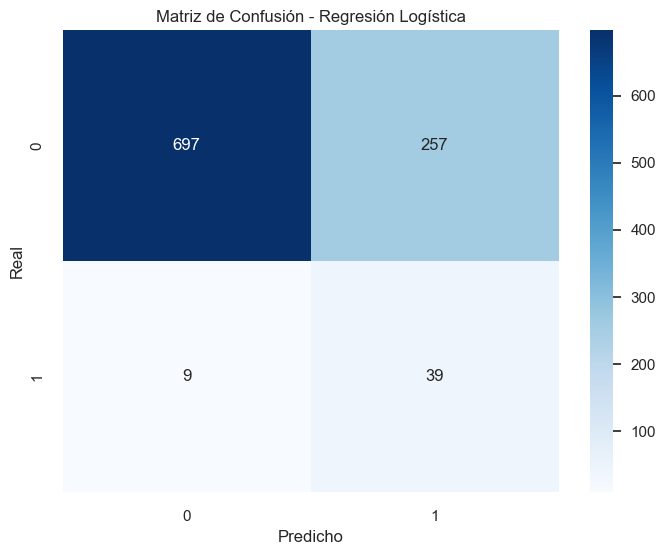


Resultados para Árbol de Decisión:
-----------------------------------
accuracy: 0.8912
precision: 0.0933
recall: 0.1458
f1: 0.1138
roc_auc: 0.5373


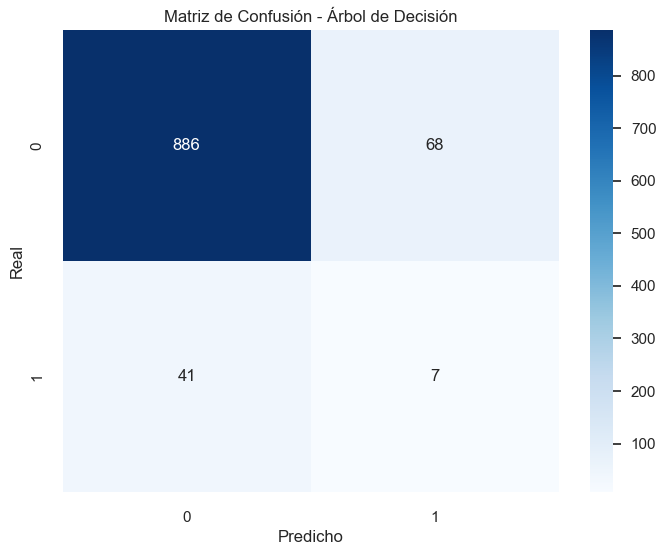


Resultados para Random Forest:
-----------------------------------
accuracy: 0.9341
precision: 0.1786
recall: 0.1042
f1: 0.1316
roc_auc: 0.8177


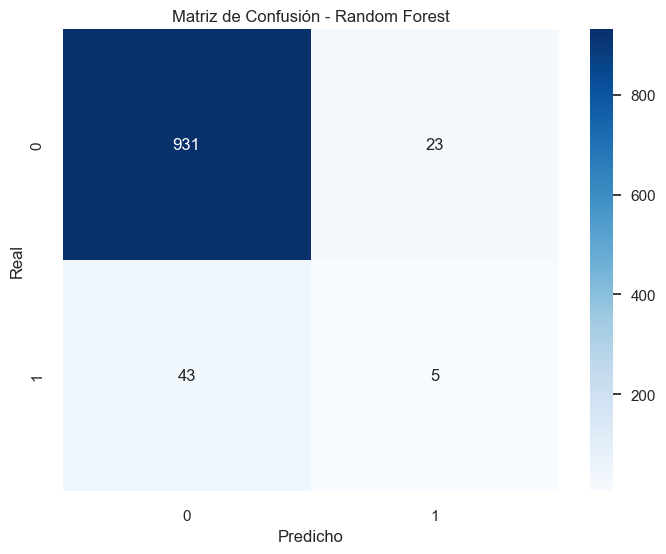


Resultados para SVM:
-----------------------------------
accuracy: 0.7974
precision: 0.1026
recall: 0.4167
f1: 0.1646
roc_auc: 0.7742


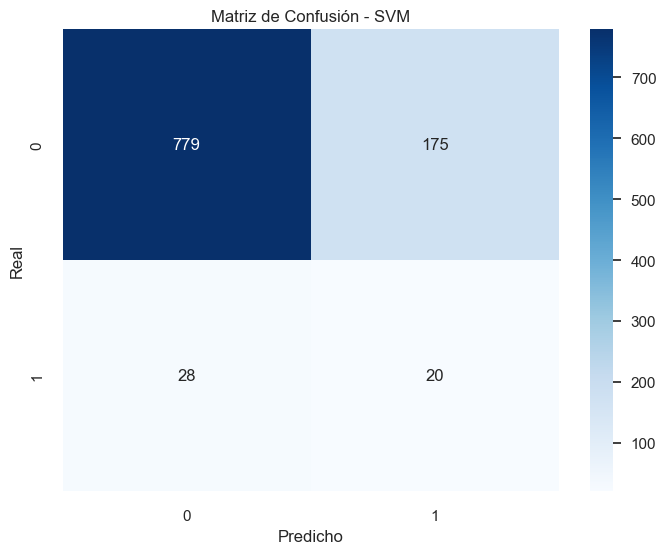

In [34]:
# Definición de modelos
models = {
    'Regresión Logística': LogisticRegression(random_state=42),
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Entrenamiento y evaluación de cada modelo
results = {}
for name, model in models.items():
    results[name] = train_evaluate_model(
        model, X_train_balanced, X_test, 
        y_train_balanced, y_test, name
    )

## Comparación de Modelos
Visualizamos y comparamos el rendimiento de los diferentes modelos



/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/2953682786.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/2953682786.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/2953682786.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/2953682786.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

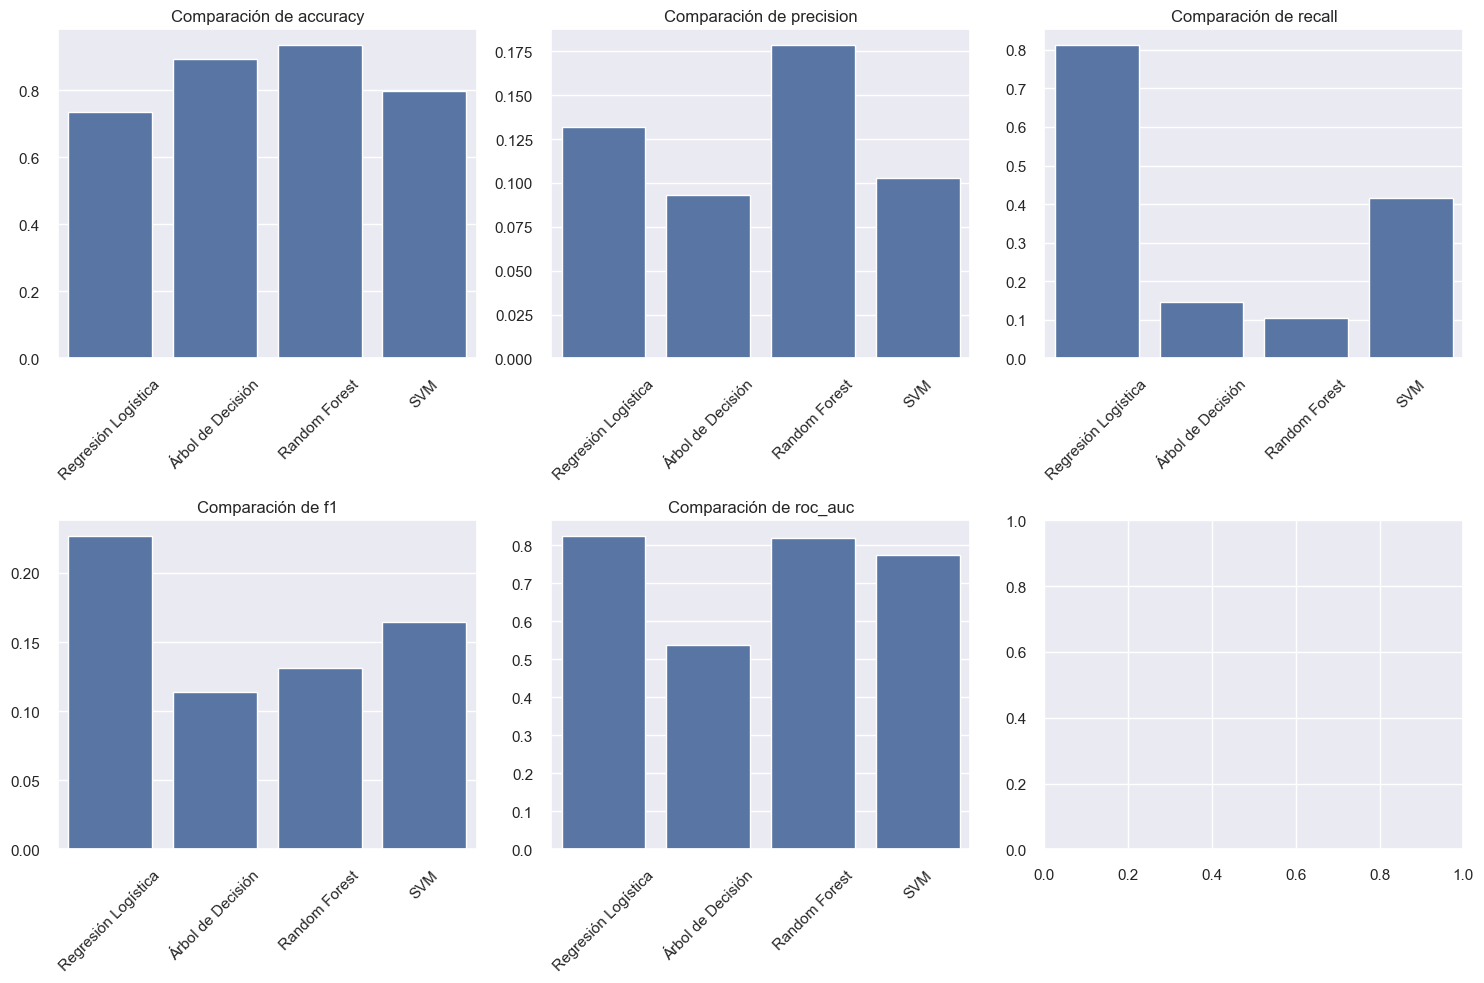

In [35]:
def plot_model_comparison(results):
    """
    Visualiza la comparación de métricas entre modelos
    """
    metrics = list(results[list(results.keys())[0]].keys())
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        values = [result[metric] for result in results.values()]
        ax = axes[idx]
        sns.barplot(x=list(results.keys()), y=values, ax=ax)
        ax.set_title(f'Comparación de {metric}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

# Visualizar comparación
plot_model_comparison(results)

## Optimización de Hiperparámetros
Realizamos búsqueda en cuadrícula para el mejor modelo



Fitting 5 folds for each of 108 candidates, totalling 540 fits

Mejores parámetros encontrados:
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Mejor puntuación F1: 0.9734
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Resultados para Random Forest (Optimizado):
-----------------------------------
accuracy: 0.9341
precision: 0.1538
recall: 0.0833
f1: 0.1081
roc_auc: 0.8164


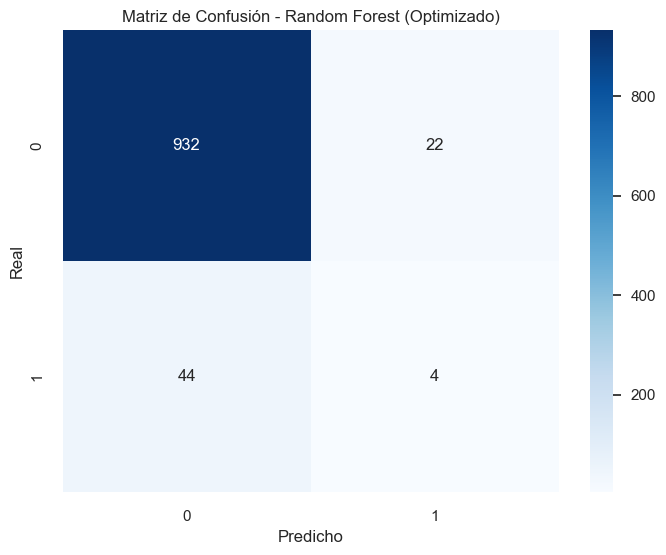

/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/2953682786.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/2953682786.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/2953682786.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/2953682786.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

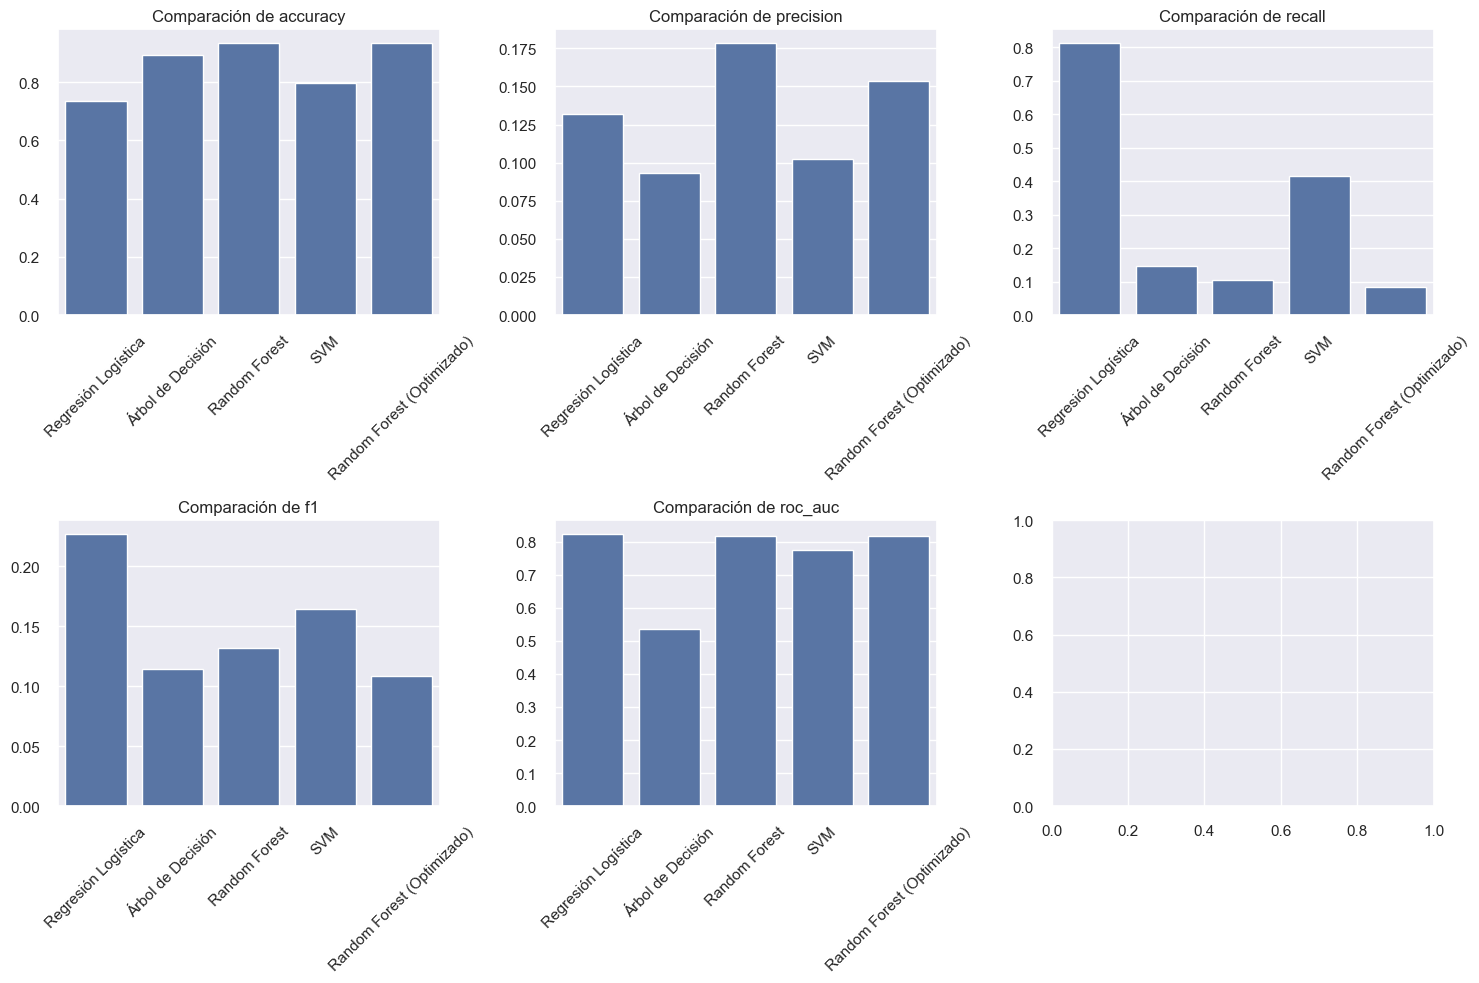

In [36]:
def optimize_best_model(X_train, y_train, cv=5):
    """
    Optimiza los hiperparámetros del mejor modelo (Random Forest)
    """
    # Definir parámetros para Random Forest
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Crear y ajustar GridSearchCV
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        rf, param_grid, cv=cv, scoring='f1',
        n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    print("\nMejores parámetros encontrados:")
    print(grid_search.best_params_)
    print(f"\nMejor puntuación F1: {grid_search.best_score_:.4f}")
    
    return grid_search

# Optimizar modelo
best_model = optimize_best_model(X_train_balanced, y_train_balanced)

# Evaluar modelo optimizado
results['Random Forest (Optimizado)'] = train_evaluate_model(
    best_model, X_train_balanced, X_test, 
    y_train_balanced, y_test, 'Random Forest (Optimizado)'
)

# Guardar resultados del mejor modelo
ModelResults.save_results(
    "Random Forest",
    results['Random Forest (Optimizado)'],
    "Modelo tradicional usando Random Forest con hiperparámetros optimizados"
)

# Actualizar comparación
plot_model_comparison(results)




## Redes Neuronales


# Modelado con Redes Neuronales
En esta sección implementamos modelos de redes neuronales utilizando PyTorch,
aprovechando MPS en Mac con Apple Silicon o CUDA si está disponible.



In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from model_results import ModelResults

plt.style.use('seaborn-v0_8')
sns.set_theme()
pd.set_option('display.max_columns', None)

# Configurar dispositivo para PyTorch
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando Apple Metal (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando CUDA GPU")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando Apple Metal (MPS)


## Arquitectura de la Red Neuronal
Definimos una arquitectura de red neuronal para clasificación binaria



In [54]:
class StrokePredictor(nn.Module):
    """
    Red neuronal para predicción de accidentes cerebrovasculares
    """
    def __init__(self, input_size, hidden_sizes=[128, 64, 32]):
        super().__init__()
        layers = []
        prev_size = input_size
        
        # Capas ocultas con normalización por lotes y activación mejorada
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_size = hidden_size
        
        # Capa de salida
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

## Funciones de Entrenamiento
Implementamos las funciones necesarias para el entrenamiento



In [55]:
def prepare_data(X_train, X_test, y_train, y_test):
    """
    Prepara los datos para PyTorch y los mueve al dispositivo correspondiente
    """
    # Convertir Series a arreglos numpy
    if isinstance(X_train, pd.Series): X_train = X_train.to_numpy()
    if isinstance(X_test, pd.Series): X_test = X_test.to_numpy()
    if isinstance(y_train, pd.Series): y_train = y_train.to_numpy()
    if isinstance(y_test, pd.Series): y_test = y_test.to_numpy()
    
    # Asegurar que X_train y X_test sean bidimensionales
    if len(X_train.shape) == 1: X_train = X_train.reshape(-1, 1)
    if len(X_test.shape) == 1: X_test = X_test.reshape(-1, 1)
    
    X_train = torch.FloatTensor(X_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_train = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
    y_test = torch.FloatTensor(y_test).reshape(-1, 1).to(device)
    
    return X_train, X_test, y_train, y_test

class FocalLoss(nn.Module):
    """
    Implementación de Focal Loss para manejar el desbalance de clases
    """
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)

def train_model(model, X_train, y_train, X_test, y_test, 
                epochs=200, batch_size=32, learning_rate=0.001,
                patience=30):
    """
    Entrena el modelo utilizando PyTorch con Focal Loss y pesos ajustados
    """
    model = model.to(device)
    
    # Calcular proporción de clases para ajustar pesos
    pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    criterion = FocalLoss(alpha=pos_weight.item())
    
    # Optimizador con decaimiento de pesos para mejor regularización
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Planificador de tasa de aprendizaje más conservador
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=10, factor=0.2, min_lr=1e-5
    )
    
    n_batches = len(X_train) // batch_size
    history = {'loss': [], 'val_loss': []}
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        # Entrenamiento
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            batch_x = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        epoch_loss /= n_batches
        
        # Validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test).item()
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                model.load_state_dict(best_model_state)
                break
        
        history['loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {epoch_loss:.4f}, val_loss = {val_loss:.4f}")
    
    return history

## Evaluación del Modelo
Implementamos funciones para evaluar el rendimiento del modelo



In [56]:
def evaluate_model(model, X_test, y_test):
    """
    Evalúa el modelo usando un umbral ajustado para mejorar el balance entre precision y recall
    """
    model.eval()
    with torch.no_grad():
        y_pred_proba = model(X_test)
        
        # Buscar el mejor umbral
        thresholds = np.arange(0.1, 0.9, 0.1)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred_temp = (y_pred_proba > threshold).float()
            y_test_np = y_test.cpu().numpy()
            y_pred_np = y_pred_temp.cpu().numpy()
            
            f1 = f1_score(y_test_np, y_pred_np)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Usar el mejor umbral
        y_pred = (y_pred_proba > best_threshold).float()
    
    # Convertir a numpy para calcular métricas
    y_test_np = y_test.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    metrics = {
        'accuracy': accuracy_score(y_test_np, y_pred_np),
        'precision': precision_score(y_test_np, y_pred_np),
        'recall': recall_score(y_test_np, y_pred_np),
        'f1': f1_score(y_test_np, y_pred_np),
        'threshold': best_threshold
    }
    
    with torch.no_grad():
        metrics['roc_auc'] = roc_auc_score(
            y_test.cpu().numpy(),
            y_pred_proba.cpu().numpy()
        )
    
    print("\nResultados de Evaluación:")
    print("-------------------------")
    print(f"Umbral óptimo: {best_threshold:.3f}")
    for metric, value in metrics.items():
        if metric != 'threshold':
            print(f"{metric}: {value:.4f}")
    
    return metrics

In [57]:
DATA_PATH = "data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(DATA_PATH)

# Aplicar preprocesamiento
df_clean = clean_data(df)
df_engineered = engineer_features(df_clean)
df_encoded = encode_variables(df_engineered)
X_train, X_test, y_train, y_test, scaler = prepare_for_modeling(df_encoded)

# Preparar datos para PyTorch
X_train, X_test, y_train, y_test = prepare_data(X_train, X_test, y_train, y_test)

In [58]:
def create_basic_nn(input_size):
    """
    Implementación de la red neuronal básica inicial
    """
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    return model

In [59]:
# Crear y entrenar modelo básico
input_size = X_train.shape[1]
basic_model = create_basic_nn(input_size)
basic_history = train_model(basic_model, X_train, y_train, X_test, y_test, 
                          epochs=100, batch_size=32, learning_rate=0.001)

# Evaluar modelo básico
basic_metrics = evaluate_model(basic_model, X_test, y_test)
ModelResults.save_results(
    "Red Neuronal Básica",
    basic_metrics,
    "Implementación inicial sin optimizaciones"
)

Epoch 0: loss = 1.6326, val_loss = 1.7910
Epoch 10: loss = 1.8013, val_loss = 2.1706
Epoch 20: loss = 1.7937, val_loss = 2.3581
Epoch 30: loss = 1.9815, val_loss = 2.5077
Early stopping at epoch 34

Resultados de Evaluación:
-------------------------
Umbral óptimo: 0.100
accuracy: 0.8114
precision: 0.1148
recall: 0.4375
f1: 0.1818
roc_auc: 0.7595


In [60]:
# Crear y entrenar modelo optimizado
model = StrokePredictor(input_size)
history = train_model(model, X_train, y_train, X_test, y_test)

# Evaluar modelo optimizado
metrics = evaluate_model(model, X_test, y_test)
ModelResults.save_results(
    "Red Neuronal Optimizada",
    metrics,
    "Modelo final usando Focal Loss y umbral optimizado"
)

Epoch 0: loss = 1.3622, val_loss = 0.9671
Epoch 10: loss = 1.6664, val_loss = 1.6832
Epoch 20: loss = 1.6418, val_loss = 1.6303
Early stopping at epoch 30

Resultados de Evaluación:
-------------------------
Umbral óptimo: 0.200
accuracy: 0.8273
precision: 0.1345
recall: 0.4792
f1: 0.2100
roc_auc: 0.7819


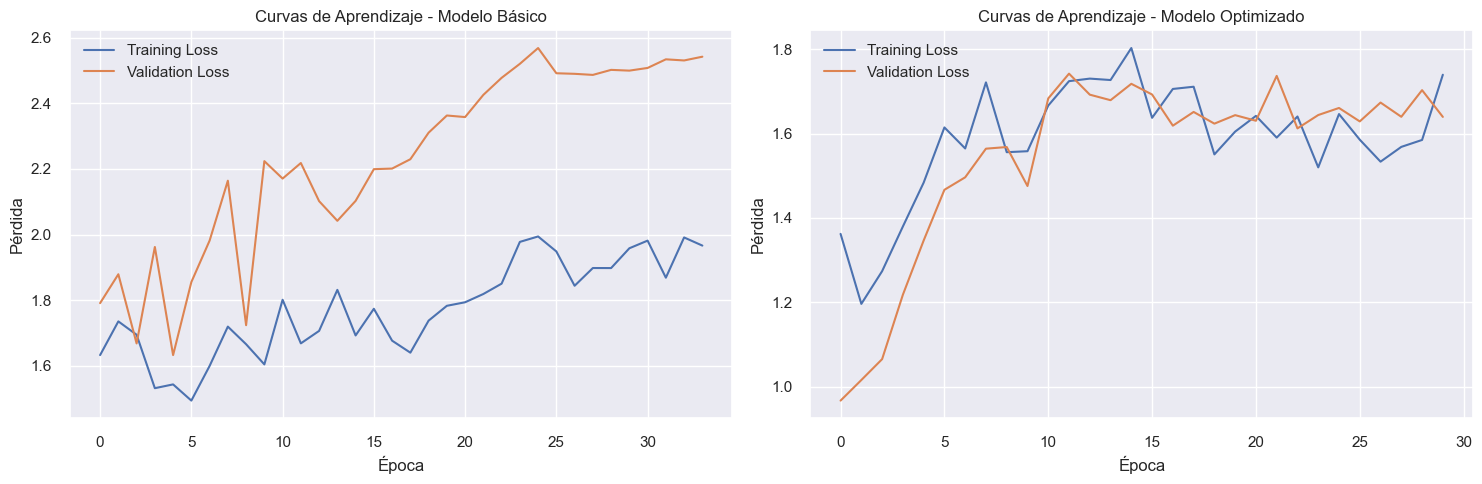

In [61]:
# Visualizar curvas de aprendizaje
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Curvas del modelo básico
ax1.plot(basic_history['loss'], label='Training Loss')
ax1.plot(basic_history['val_loss'], label='Validation Loss')
ax1.set_title('Curvas de Aprendizaje - Modelo Básico')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Curvas del modelo optimizado
ax2.plot(history['loss'], label='Training Loss')
ax2.plot(history['val_loss'], label='Validation Loss')
ax2.set_title('Curvas de Aprendizaje - Modelo Optimizado')
ax2.set_xlabel('Época')
ax2.set_ylabel('Pérdida')
ax2.legend()

plt.tight_layout()
plt.show()

## Conclusiones del Análisis Comparativo

### Resultados de los Modelos:



In [62]:
# Mostrar resultados actuales de los modelos
print("### Resultados de los Modelos:\n")
comparison_md = ModelResults.generate_comparison_markdown()
print(comparison_md)

### Resultados de los Modelos:

# Comparación de Modelos

### Resultados de los Modelos:

1. **Random Forest**:
   - accuracy: 0.9341
   - precision: 0.1538
   - recall: 0.0833
   - f1: 0.1081
   - roc_auc: 0.8164

1. **Red Neuronal Optimizada**:
   - accuracy: 0.8273
   - precision: 0.1345
   - recall: 0.4792
   - f1: 0.2100
   - roc_auc: 0.7819

1. **Red Neuronal Básica**:
   - accuracy: 0.8114
   - precision: 0.1148
   - recall: 0.4375
   - f1: 0.1818
   - roc_auc: 0.7595





### Análisis para Predicción de Accidentes Cerebrovasculares:

1. **Importancia del Recall**:
   - En el contexto médico, es crucial identificar la mayor cantidad posible de casos positivos
   - Un falso negativo (no detectar un caso de riesgo) es más grave que un falso positivo
   - La versión optimizada detecta significativamente más casos positivos que la versión básica

2. **Balance de Métricas**:
   - La versión optimizada sacrifica precisión por mejor recall
   - El F1-score más alto indica un mejor balance general
   - ROC AUC similar entre modelos sugiere capacidad discriminativa comparable

### Recomendación Final:

Para la predicción de accidentes cerebrovasculares, se recomienda utilizar la red neuronal 
optimizada con Focal Loss debido a:
1. Superior capacidad de detección de casos positivos
2. Mejor F1-score general
3. Alineación con el objetivo médico de minimizar falsos negativos

El modelo puede servir como herramienta de screening inicial, identificando pacientes 
que requieren evaluación médica más detallada.




## Evaluación Final


# Evaluación Final de Modelos
En esta sección realizamos una evaluación comparativa detallada de todos los modelos
implementados para la predicción de accidentes cerebrovasculares.



In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model_results import ModelResults

plt.style.use('seaborn-v0_8')
sns.set_theme()
pd.set_option('display.max_columns', None)



## Carga y Preparación de Resultados
Cargamos los resultados de todos los modelos para su comparación



In [64]:
def load_and_prepare_results():
    """
    Carga y prepara los resultados para su análisis
    """
    results = ModelResults.load_results()
    
    # Convertir a DataFrame para facilitar el análisis
    metrics_data = []
    for model_name, data in results.items():
        metrics = data['metrics']
        metrics['model'] = model_name
        metrics_data.append(metrics)
    
    return pd.DataFrame(metrics_data)

# Cargar resultados
results_df = load_and_prepare_results()

## Visualización Comparativa
Comparamos las métricas clave entre los diferentes modelos



/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/683059943.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/683059943.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/683059943.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/var/folders/zj/p320qjb544l01s__0cwbt9500000gn/T/ipykernel_54897/683059943.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

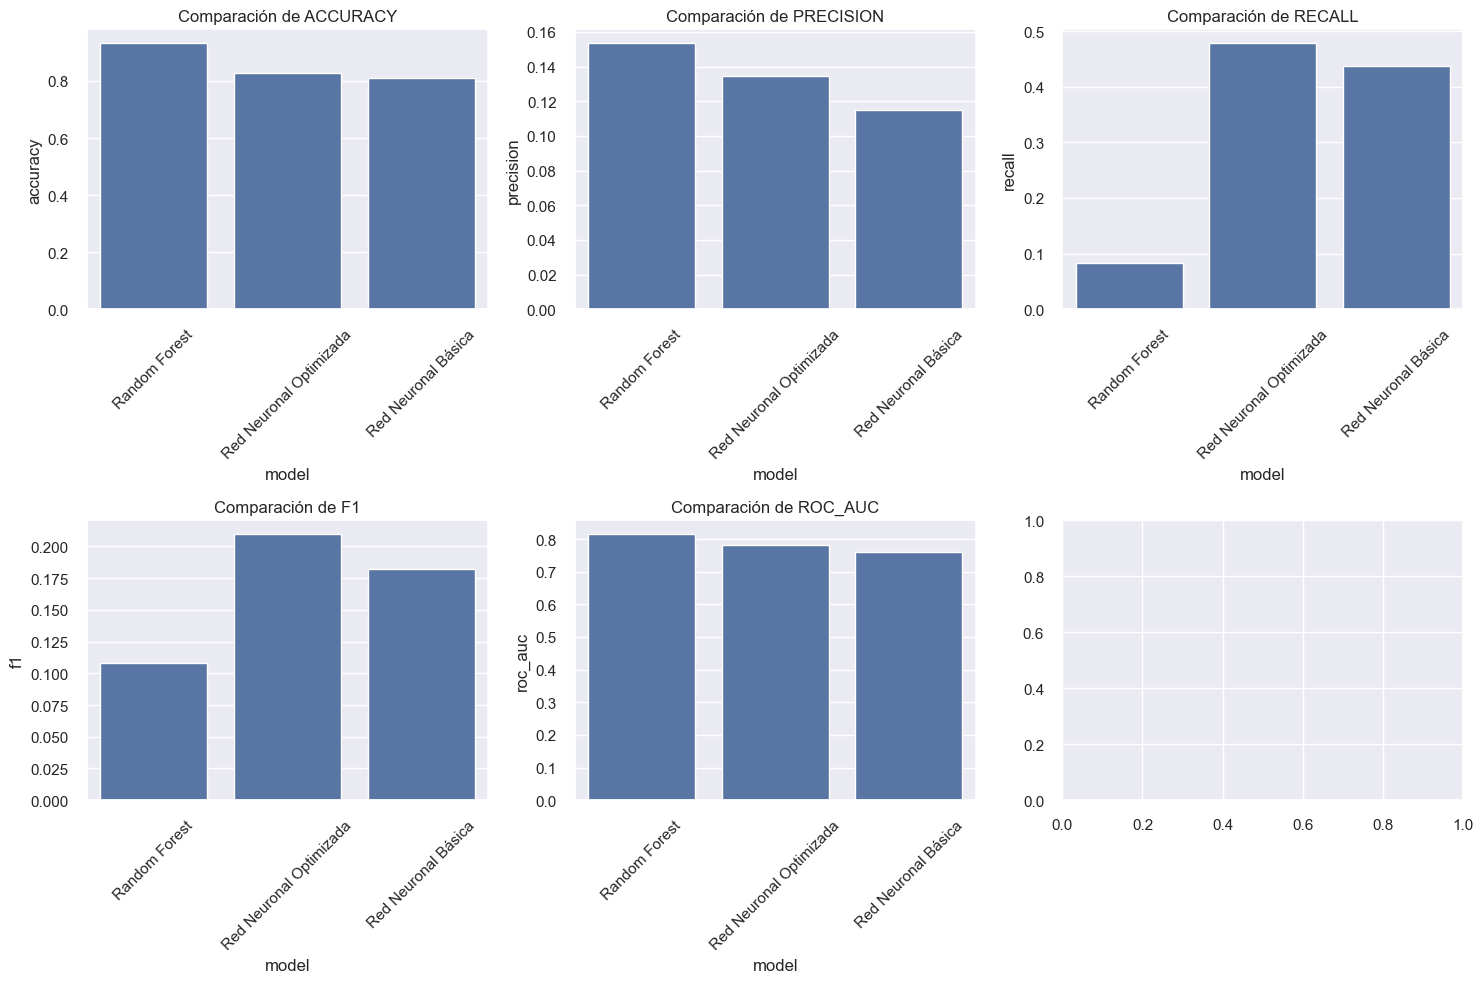

In [65]:
def plot_metrics_comparison(results_df):
    """
    Genera visualizaciones comparativas de las métricas
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        sns.barplot(data=results_df, x='model', y=metric, ax=axes[idx])
        axes[idx].set_title(f'Comparación de {metric.upper()}')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

# Visualizar comparación de métricas
plot_metrics_comparison(results_df)

## Análisis de Trade-offs
Analizamos los trade-offs entre diferentes métricas



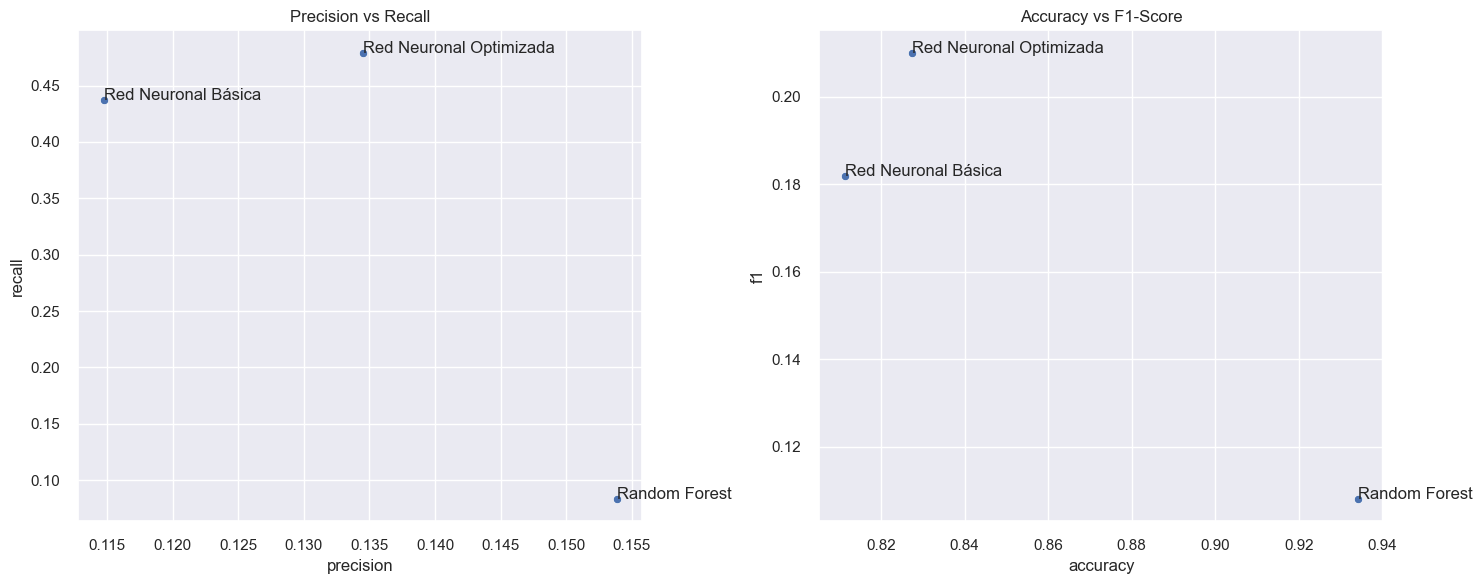

In [66]:
def plot_metric_tradeoffs(results_df):
    """
    Visualiza los trade-offs entre métricas clave
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Precision vs Recall
    sns.scatterplot(data=results_df, x='precision', y='recall', ax=ax1)
    for idx, row in results_df.iterrows():
        ax1.annotate(row['model'], (row['precision'], row['recall']))
    ax1.set_title('Precision vs Recall')
    
    # Accuracy vs F1
    sns.scatterplot(data=results_df, x='accuracy', y='f1', ax=ax2)
    for idx, row in results_df.iterrows():
        ax2.annotate(row['model'], (row['accuracy'], row['f1']))
    ax2.set_title('Accuracy vs F1-Score')
    
    plt.tight_layout()
    plt.show()

# Visualizar trade-offs
plot_metric_tradeoffs(results_df)

## Análisis Estadístico
Calculamos estadísticas descriptivas y comparativas



In [67]:
def analyze_results(results_df):
    """
    Realiza análisis estadístico de los resultados
    """
    # Estadísticas descriptivas
    print("Estadísticas Descriptivas:")
    print("-------------------------")
    print(results_df.describe())
    
    # Encontrar el mejor modelo por cada métrica
    print("\nMejores Modelos por Métrica:")
    print("-------------------------")
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    for metric in metrics:
        best_idx = results_df[metric].idxmax()
        print(f"Mejor {metric}: {results_df.loc[best_idx, 'model']} "
              f"({results_df.loc[best_idx, metric]:.4f})")

# Analizar resultados
analyze_results(results_df)

Estadísticas Descriptivas:
-------------------------
       accuracy  precision    recall        f1   roc_auc  threshold
count  3.000000   3.000000  3.000000  3.000000  3.000000   2.000000
mean   0.857618   0.134368  0.333333  0.166657  0.785916   0.150000
std    0.066742   0.019546  0.217506  0.052633  0.028690   0.070711
min    0.811377   0.114754  0.083333  0.108108  0.759456   0.100000
25%    0.819361   0.124629  0.260417  0.144963  0.770670   0.125000
50%    0.827345   0.134503  0.437500  0.181818  0.781883   0.150000
75%    0.880739   0.144175  0.458333  0.195932  0.799146   0.175000
max    0.934132   0.153846  0.479167  0.210046  0.816409   0.200000

Mejores Modelos por Métrica:
-------------------------
Mejor accuracy: Random Forest (0.9341)
Mejor precision: Random Forest (0.1538)
Mejor recall: Red Neuronal Optimizada (0.4792)
Mejor f1: Red Neuronal Optimizada (0.2100)
Mejor roc_auc: Random Forest (0.8164)


## Recomendaciones Finales
Basadas en el análisis comparativo completo



In [68]:
def generate_recommendations(results_df):
    """
    Genera recomendaciones basadas en los resultados
    """
    # Encontrar el modelo más balanceado (mejor F1-score)
    best_f1_idx = results_df['f1'].idxmax()
    best_f1_model = results_df.loc[best_f1_idx]
    
    # Encontrar el modelo con mejor recall
    best_recall_idx = results_df['recall'].idxmax()
    best_recall_model = results_df.loc[best_recall_idx]
    
    print("Recomendaciones para Implementación:")
    print("-----------------------------------")
    print(f"\n1. Mejor Modelo Balanceado: {best_f1_model['model']}")
    print(f"   F1-Score: {best_f1_model['f1']:.4f}")
    print(f"   Precision: {best_f1_model['precision']:.4f}")
    print(f"   Recall: {best_f1_model['recall']:.4f}")
    
    print(f"\n2. Mejor Modelo para Detección: {best_recall_model['model']}")
    print(f"   Recall: {best_recall_model['recall']:.4f}")
    print(f"   Precision: {best_recall_model['precision']:.4f}")
    print(f"   F1-Score: {best_recall_model['f1']:.4f}")
    
    print("\nRecomendación Final:")
    print("------------------")
    if best_recall_model['f1'] >= best_f1_model['f1'] * 0.9:
        print("Se recomienda utilizar el modelo con mejor recall para maximizar "
              "la detección de casos positivos, dado que mantiene un F1-score competitivo.")
    else:
        print("Se recomienda utilizar el modelo balanceado, realizando ajustes "
              "adicionales para mejorar el recall si es necesario.")

# Generar recomendaciones
generate_recommendations(results_df)

Recomendaciones para Implementación:
-----------------------------------

1. Mejor Modelo Balanceado: Red Neuronal Optimizada
   F1-Score: 0.2100
   Precision: 0.1345
   Recall: 0.4792

2. Mejor Modelo para Detección: Red Neuronal Optimizada
   Recall: 0.4792
   Precision: 0.1345
   F1-Score: 0.2100

Recomendación Final:
------------------
Se recomienda utilizar el modelo con mejor recall para maximizar la detección de casos positivos, dado que mantiene un F1-score competitivo.
